# Quadgrid
The `quadgrid` package provides a class and some convenience functions 
for generating quadtree-based grids at arbitrary resolutions in pandas, geopandas and xarray formats for use in geospatial analysis and catastrophe risk modelling. 

## Overview
Quadtree grids are a way of recursively partitioning a plane into
nested quadrants, allowing for simple but efficient geocoding of
points.

Some assumptions have been made to simplify the package:
- all coordinates are in decimal degrees
- all longitudes range from -180 to +180 degrees
- the centre of the grid is at 0E, 0N

The package contains a single class, `QuadGrid`, which is used to
generate grid objects. The class has methods to convert the grid into
tabular (pandas DataFrame), vector (geopandas GeoDataFrame) and raster
(xarray Dataset) formats which can be saved or used in further processing.

Individual quadcells at a given resolution are labelled with unique
quadtreeIDs (qids). In the simplified example below, the red point is in top-level cell '2', then cell '2', then '0' then '3' giving a nominal qid of '2203'. In practice, quadtrees lend themselves to a base-4 encoding, allowing them to be stored and processed efficiently as integers.

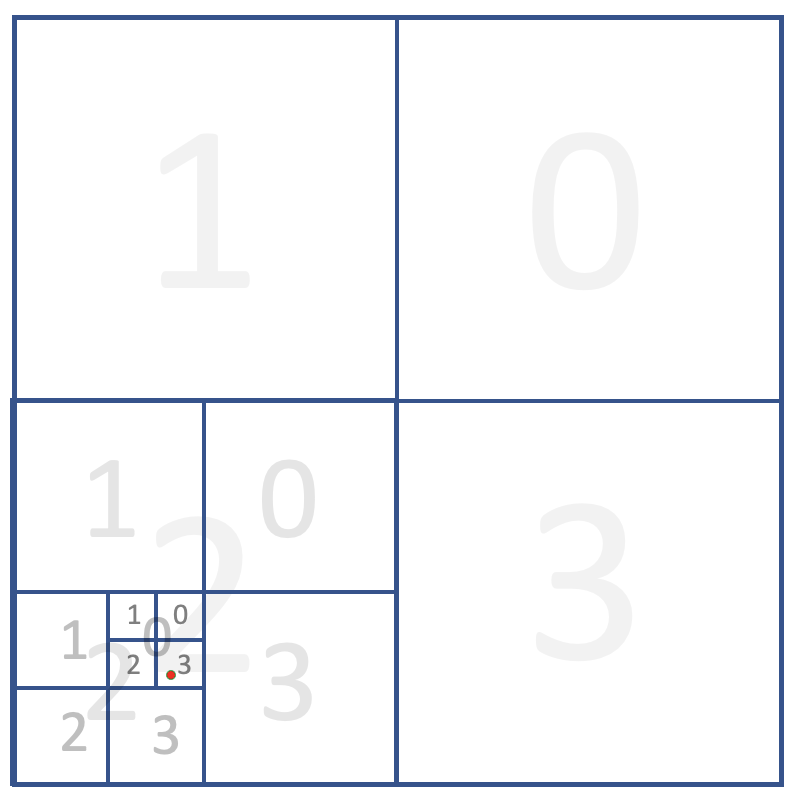

## Examples

In [1]:
import quadgrid as qg
import matplotlib.pyplot as plt
import geopandas as gpd
import geodatasets as gds
from shapely.geometry import box

Load shapefiles for examples.

In [2]:
path = gds.get_path('naturalearth.land')
world = gpd.read_file(path)
world.head(2)

,featurecla,scalerank,min_zoom,geometry
0,Land,1,1.0,"POLYGON ((-59.57209 -80.04018, -59.86585 -80.5..."
1,Land,1,1.0,"POLYGON ((-159.20818 -79.49706, -161.1276 -79...."


In [3]:
path = gds.get_path('abs.australia')
aus = gpd.read_file(path)
aus.head(2)

,AUS_CODE21,AUS_NAME21,CHG_FLAG21,CHG_LBL21,AREASQKM21,LOCI_URI21,geometry
0,AUS,Australia,0,No change,7.688095e+06,http://linked.data.gov.au/dataset/asgsed3/AUS/AUS,"MULTIPOLYGON (((96.91524 -12.15313, 96.91523 -..."
1,ZZZ,Outside Australia,1,New,NaN,http://linked.data.gov.au/dataset/asgsed3/AUS/ZZZ,None


### Global low-resolution grid

Create global quadgrid at 2.0$^{\circ}$ resolution:

In [4]:
q200_world = qg.QuadGrid(2)
q200_world

QuadGrid 2 deg | -180<=lon<=180 | -90<=lat<=90

Apply a shapely geometry object (either a geopandas GeoDataFrame or shapely [Multi]Polygon) as a mask:

In [5]:
q200_world.apply_mask(gdf=world)

In [6]:
q200_world_xr = q200_world.to_xarray()
q200_world_xr

<xarray.Dataset> Size: 407kB
Dimensions:  (lat: 90, lon: 180)
Coordinates:
  * lat      (lat) float64 720B -89.0 -87.0 -85.0 -83.0 ... 83.0 85.0 87.0 89.0
  * lon      (lon) float64 1kB -179.0 -177.0 -175.0 -173.0 ... 175.0 177.0 179.0
Data variables:
    qid      (lat, lon) int64 130kB 40369 40368 40421 ... 14159 14106 14107
    res      (lat, lon) int64 130kB 2 2 2 2 2 2 2 2 2 2 ... 2 2 2 2 2 2 2 2 2 2
    area     (lat, lon) float64 130kB 863.1 863.1 863.1 ... 863.1 863.1 863.1
    mask     (lat, lon) bool 16kB True True True True ... False False False
Attributes:
    Type:        quadgrid
    Resolution:  2 deg
    Area units:  km2

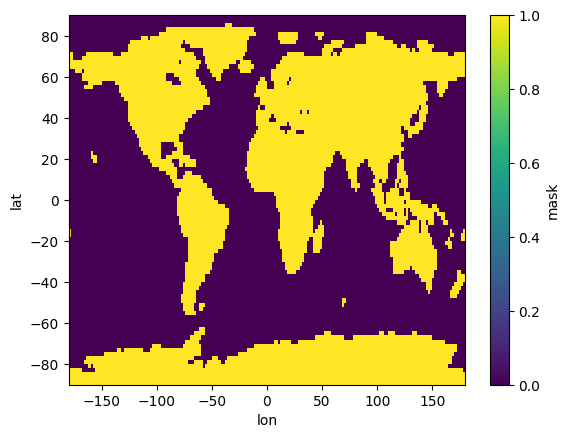

In [7]:
q200_world_xr['mask'].plot();

In [8]:
q200_world_gpd = q200_world.to_geopandas()
q200_world_gpd

,lat,lon,qid,res,area,mask,geometry
0,-89.0,-179.0,40369,2,863.106049,True,"POLYGON ((-178 -88, -178 -90, -180 -90, -180 -..."
1,-89.0,-177.0,40368,2,863.106049,True,"POLYGON ((-176 -88, -176 -90, -178 -90, -178 -..."
2,-89.0,-175.0,40421,2,863.106049,True,"POLYGON ((-174 -88, -174 -90, -176 -90, -176 -..."
3,-89.0,-173.0,40420,2,863.106049,True,"POLYGON ((-172 -88, -172 -90, -174 -90, -174 -..."
4,-89.0,-171.0,40417,2,863.106049,True,"POLYGON ((-170 -88, -170 -90, -172 -90, -172 -..."
...,...,...,...,...,...,...,...
16195,89.0,171.0,14155,2,863.106049,False,"POLYGON ((172 90, 172 88, 170 88, 170 90, 172 ..."
16196,89.0,173.0,14158,2,863.106049,False,"POLYGON ((174 90, 174 88, 172 88, 172 90, 174 ..."
16197,89.0,175.0,14159,2,863.106049,False,"POLYGON ((176 90, 176 88, 174 88, 174 90, 176 ..."
16198,89.0,177.0,14106,2,863.106049,False,"POLYGON ((178 90, 178 88, 176 88, 176 90, 178 ..."


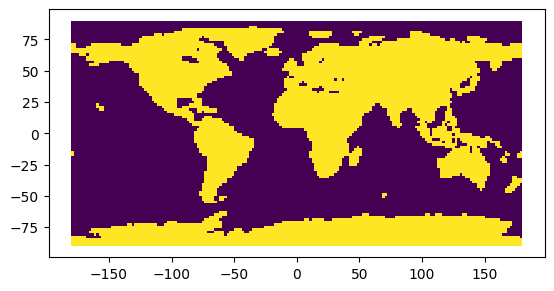

In [9]:
q200_world_gpd.plot(column='mask', cmap='viridis');

### Australia medium-resolution grid

Make a regional grid over Australia at 1$^{\circ}$ resolution:

In [10]:
q100_Aus = qg.QuadGrid(1, lon_bounds=(96, 168), lat_bounds=(-43, -9))
q100_Aus

QuadGrid 1 deg | 96<=lon<=168 | -43<=lat<=-9

Visualise the effect of applying a geometric mask with different buffering assumptions. The geometric mask is a simplified, conservative version of a spatial join, doing a fast point-in-polygon check for all gridcells. "Conservative" means it will flag some cells as intersecting with the geometry which in fact do not, but should not miss any cells which do intersect. 

In the left-hand plot (without buffering) we can see that there are areas within the geometry that don't have an associated quadcell. For those cells, this is because the centroid falls outside the geometry, even if some other part of the cell falls inside. The `pct_conservative` argument of the `apply_mask` function controls the level of buffering. The default is optimal, but buffering can be turned off by passing `pct_conservative=-100`,

In [11]:
aus_geom = aus.loc[0, 'geometry']

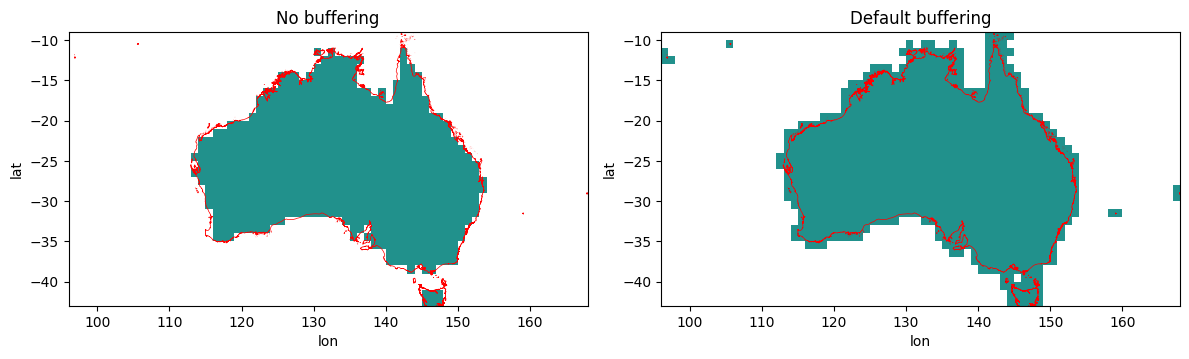

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,8))
q100_Aus.apply_mask(poly=aus_geom, pct_conservative=-100)
q100_Aus.to_xarray()['mask'].where(q100_Aus.to_xarray()['mask']).plot(ax=ax1, add_colorbar=False)
aus.boundary.plot(ax=ax1, color='r', lw=0.5)
ax1.set_title('No buffering')
q100_Aus.apply_mask(poly=aus_geom, pct_conservative=None)
q100_Aus.to_xarray()['mask'].where(q100_Aus.to_xarray()['mask']).plot(ax=ax2, add_colorbar=False)
aus.boundary.plot(ax=ax2, color='r', lw=0.5)
ax2.set_title('Default buffering')
fig.tight_layout();

### Distance operations

The `distance()` method calculates the distances from a single point to all grid centroids. For example, the following calculates the distances from Uluru of all quadcells on the Australia subgrid.

In [13]:
uluru_lonlat = 131.03508584877616, -25.34515246352663

In [14]:
dist = q100_Aus.distance(*uluru_lonlat)
dist

lat    lon  
-42.5  96.5     3676.184691
       97.5     3599.458579
       98.5     3523.298776
       99.5     3447.751383
       100.5    3372.866002
                   ...     
-9.5   163.5    3852.207806
       164.5    3946.078271
       165.5    4040.483612
       166.5    4135.384184
       167.5    4230.743598
Name: distance_km, Length: 2448, dtype: float64

Convert to xarray and use the xarray version of the UK mask to filter out non-land, then plot:

In [15]:
dist_da = dist.to_xarray()

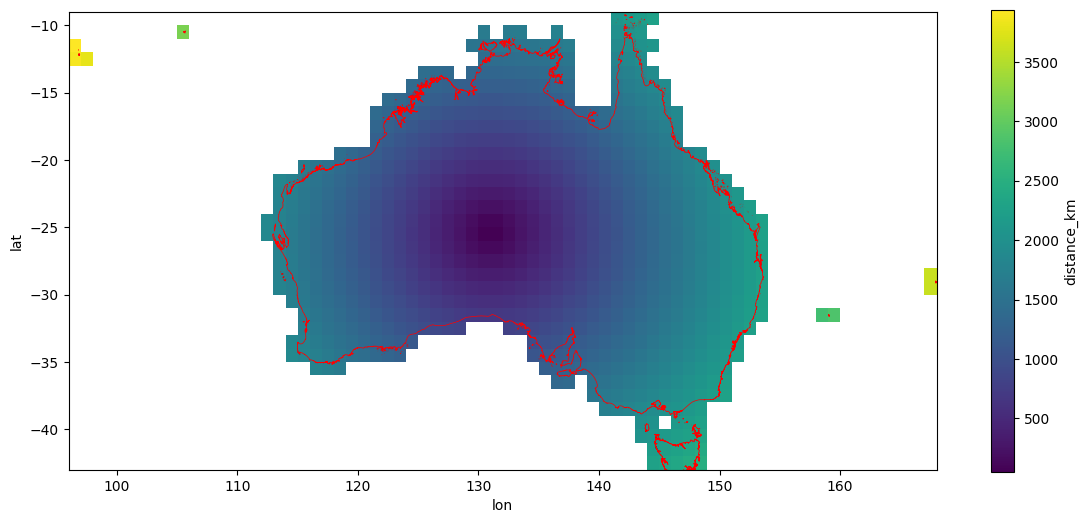

In [16]:
fig, ax = plt.subplots(figsize=(14,6))
dist_da.where(q100_Aus.to_xarray()['mask']).plot(ax=ax)
aus.boundary.plot(ax=ax, color='r', lw=0.5);